# Sample Clarius Analysis

# Select Image & Phantom and Parse

In [1]:
from pyquantus.parse.clarius import clariusRfParser

rf_path = '/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_rf.raw'
rf_tgc_path = '/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml'
info_path = '/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_rf.yml'

imgData, imgInfo, refData, refInfo = clariusRfParser(rf_path, rf_tgc_path, info_path,
                                                    rf_path, rf_tgc_path, info_path)

The number of missing timestamps for /Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml is: 30. Skipping this scan with current criteria.
A default TGC matrix of size (192, 2928, 30) is generated.
A default TGC matrix of size (192, 2928, 30) is generated.
The number of missing timestamps for /Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml is: 30. Skipping this scan with current criteria.
A default TGC matrix of size (192, 2928, 30) is generated.
A default TGC matrix of size (192, 2928, 30) is generated.


# ROI Selection (from GUI)

In [2]:
import pickle

pkl_name = "/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/roi.pkl"

with open(pkl_name, 'rb') as f:
    roi_info = pickle.load(f)

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_92445/3772181726.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  roi_info = pickle.load(f)


In [3]:
from pathlib import Path

assert roi_info['Image Name'] == Path(rf_path).name
assert roi_info['Phantom Name'] == Path(rf_path).name

In [4]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]
frame = roi_info["Frame"]

# Analysis Config (from GUI)

In [5]:
from pyquantus.utc import AnalysisConfig

config = AnalysisConfig()

config.transducerFreqBand = [0, 8000000] # [min, max] (Hz)
config.analysisFreqBand = [2000000, 6000000] # [lower, upper] (Hz)
config.samplingFrequency = 15000000 # Hz
config.axWinSize = 3.85 # axial length per window (mm)
config.latWinSize = 3.85 # lateral length per window (mm)
config.windowThresh = 0.95 # % of window area required to be considered in ROI
config.axialOverlap = 0.5 # % of window overlap in axial direction
config.lateralOverlap = 0.5 # % of window overlap in lateral direction
config.centerFrequency = 4000000 # Hz

# UTC Analysis

In [6]:
from pyquantus.utc import UltrasoundImage

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfo.depth / imgData.rf[frame].shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgData.rf[frame].shape[0]/imgData.rf[frame].shape[1]
) # placeholder
ultrasoundImage.bmode = imgData.bMode[frame]
ultrasoundImage.scBmode = imgData.scBmode[frame]
ultrasoundImage.phantomRf = refData.rf[0]
ultrasoundImage.rf = imgData.rf[frame]
ultrasoundImage.xmap = imgData.scBmodeStruct.xmap
ultrasoundImage.ymap = imgData.scBmodeStruct.ymap

In [7]:
from pyquantus.utc import UtcAnalysis

utcAnalysis = UtcAnalysis()
utcAnalysis.ultrasoundImage = ultrasoundImage
utcAnalysis.config = config
utcAnalysis.initAnalysisConfig()
utcAnalysis.scSplineX = scSplineX
utcAnalysis.scSplineY = scSplineY

In [ ]:
utcAnalysis.refAttenuation = 0.5 # placeholder for attenuation coefficient at center freq (db/cm)
utcAnalysis.refBackScatterCoef = 10e-3 # placeholder for backscatter coefficient at center freq (cm^-1 sr^-1)

In [8]:
utcAnalysis.splineToPreSc()
utcAnalysis.generateRoiWindows()
utcAnalysis.computeUtcWindows()

/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS/.venv/lib/python3.11/site-packages/pyquantus/qus/analysis.py:193: RuntimeWarning: divide by zero encountered in divide
  u = (w**2) / np.var((r / p) ** 2, axis=1)


In [ ]:
import numpy as np

mbfArr = [window.results.mbf for window in utcAnalysis.roiWindows]
ssArr = [window.results.ss for window in utcAnalysis.roiWindows]
siArr = [window.results.si for window in utcAnalysis.roiWindows]

print("Average Midband Fit:", np.mean(mbfArr), "dB")
print("Average Spectral Slope:", np.mean(ssArr), "dB/MHz")
print("Average Spectral Intercept:", np.mean(siArr), "dB")
print("Attenuation Coefficient:", utcAnalysis.attenuationCoef, "dB/cm")
print("Backscatter Coefficient:", utcAnalysis.backScatterCoef, "1/cm-sr")
print("w Nakagami Parameter:", utcAnalysis.nakagamiParams[0])
print("u Nakagami Parameter:", utcAnalysis.nakagamiParams[1])
print("Effective Scatterer Diameter:", utcAnalysis.effectiveScattererDiameter, "Âµm") 
print("Effective Scatterer Concentration:", utcAnalysis.effectiveScattererConcentration, "dB/mm^3")

# Visualizations

In [9]:
from pyquantus.utc import UtcData
from pyquantus.parse.objects import ScConfig

scConfig = ScConfig()
scConfig.width = imgInfo.width1
scConfig.tilt = imgInfo.tilt1
scConfig.startDepth = imgInfo.startDepth1
scConfig.endDepth = imgInfo.endDepth1

utcData = UtcData()
utcData.utcAnalysis = utcAnalysis
utcData.scConfig = scConfig

In [10]:
utcData.convertImagesToRGB()

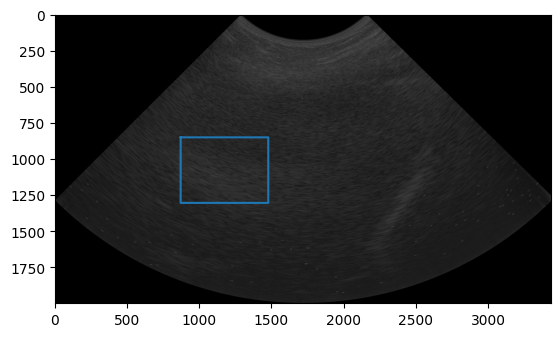

In [11]:
import matplotlib.pyplot as plt

plt.imshow(utcData.scBmode)
plt.plot(scSplineX, scSplineY)

In [12]:
utcData.drawCmaps()
utcData.scanConvertCmaps()

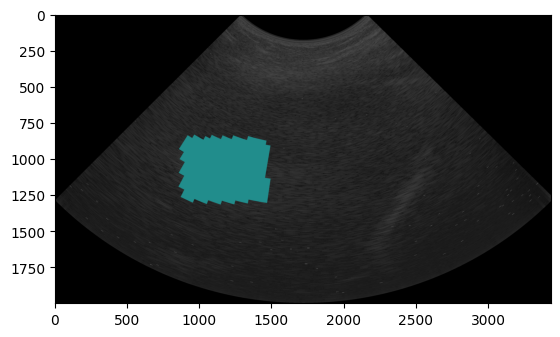

In [13]:
# Note cmap is solid as image = phantom in this case
plt.imshow(utcData.scMbfIm) 